In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
df_cleaned = pd.read_csv("/content/df_cleaned.csv")

In [ ]:

def handle_missing_values(df, app_number):
    # Step 1: Remove duplicate rows first
    df = df.drop_duplicates()

    # Step 2: Fill missing values in the target column 'ARR_DEL15' using its median
    # We use the median to keep the target class (y) to be binary. If we repalce with mean -> we might end up with continuous values which is undesirable.
    df.loc[:, 'ARR_DEL15'] = df['ARR_DEL15'].fillna(df['ARR_DEL15'].mode()[0])

    # Step 3: Handle missing values
    if app_number == 1:
        df_app = df.copy()
        # Approach 1: We will use skewness to determine whether to fill missing values with mean(mean for low skew) or median(median for high skew)
        for column in df.select_dtypes(include=['number']).columns:
            if df_app[column].skew() < 1:  # If skewness is low --> use mean
                df_app[column] = df_app[column].fillna(df_app[column].mean())
            else:  # If skewness is high --> use median
                df_app[column] = df_app[column].fillna(df_app[column].median())

    elif app_number == 2:
        # Approach 2: Replace all numeric missing values with the mean
        df_app = df.copy()
        for column in df.select_dtypes(include=['number']).columns:
            df_app[column] = df_app[column].fillna(df_app[column].mean())

    elif app_number == 3:
        # Approach 3: Similar to Approach 2 (Replace all numeric missing values with the mean)
        df_app = df.copy()
        for column in df.select_dtypes(include=['number']).columns:
            df_app[column] = df_app[column].fillna(df_app[column].mean())

    elif app_number == 4:
        # Approach 4: Remove rows that contain any missing values
        df_app = df.dropna()

    else:
        raise ValueError("Invalid app_number. Please choose a value between 1 and 4.")

    return df_app

# Which is the best encoding for our situation?

We tried 3 types of encoding


1.   One Hot Encoding
2.   Frequency Encoding
3.   Label Encoding
4.   Ordinal Encoding

  

In [ ]:
# X= pd.get_dummies(X, columns=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'], drop_first=True, dtype = int)
# for col in ['ORIGIN', 'DEST']:
#     freq_map = X[col].value_counts(normalize=True)  # Get category frequencies
#     X[col] = X[col].map(freq_map)  # Replace category with its frequency

In [ ]:
df_cleaned.select_dtypes('O').head()

,OP_UNIQUE_CARRIER,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR
0,AA,ABQ,NM,DFW,TX
1,AA,ABQ,NM,DFW,TX
2,AA,ABQ,NM,DFW,TX
3,AA,ABQ,NM,DFW,TX
4,AA,ABQ,NM,DFW,TX


In [ ]:
df_cleaned.ORIGIN_STATE_ABR.unique()

array(['NM', 'NY', 'TX', 'GA', 'CT', 'AL', 'TN', 'MA', 'CA', 'MD', 'OH',
       'NC', 'CO', 'KY', 'VA', 'IA', 'MI', 'NJ', 'FL', 'HI', 'KS', 'IN',
       'WY', 'NV', 'AR', 'MO', 'PA', 'MN', 'LA', 'OK', 'NE', 'IL', 'OR',
       'AZ', 'RI', 'WA', 'PR', 'UT', 'VI', 'AK', 'SC', 'WI', 'ME', 'MT',
       'ID', 'MS', 'ND', 'SD', 'VT', 'NH', 'WV'], dtype=object)

In [ ]:
df_cleaned.DEST_STATE_ABR.unique()

array(['TX', 'IL', 'FL', 'CA', 'PR', 'NY', 'NM', 'GA', 'CT', 'AL', 'TN',
       'MA', 'MD', 'OH', 'NC', 'CO', 'KY', 'VA', 'IA', 'MI', 'NJ', 'HI',
       'KS', 'IN', 'NV', 'AR', 'MO', 'MN', 'LA', 'OK', 'NE', 'OR', 'PA',
       'AZ', 'WA', 'UT', 'VI', 'WY', 'RI', 'AK', 'SC', 'ME', 'WI', 'MS',
       'MT', 'ID', 'ND', 'SD', 'VT', 'NH', 'WV'], dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split


# Handling missing values in the DataFrame using the approach 4
app_number = 4
df_cleaned = handle_missing_values(df_cleaned, app_number)

# Prepare features (X) and target (y) for modeling
X = df_cleaned.drop(columns=['ARR_DEL15'])
y = df_cleaned['ARR_DEL15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Encoding only using Traning data and then transform Test data

Label Encoder cannot handle values which are first time appearing in test data (Unseen Data). Also, Ordinal Encoder is better suited for feature encoding (X columns) when compared to Label Encoder

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

# =========================
# Shared encoder for ORIGIN and DEST
# =========================
airport_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
airport_encoder.fit(X_train[['ORIGIN', 'DEST']])

X_train[['ORIGIN', 'DEST']] = airport_encoder.transform(X_train[['ORIGIN', 'DEST']])
X_test[['ORIGIN', 'DEST']] = airport_encoder.transform(X_test[['ORIGIN', 'DEST']])

# =========================
# Shared encoder for ORIGIN_STATE_ABR and DEST_STATE_ABR
# =========================
state_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
state_encoder.fit(X_train[['ORIGIN_STATE_ABR', 'DEST_STATE_ABR']])

X_train[['ORIGIN_STATE_ABR', 'DEST_STATE_ABR']] = state_encoder.transform(
    X_train[['ORIGIN_STATE_ABR', 'DEST_STATE_ABR']]
)
X_test[['ORIGIN_STATE_ABR', 'DEST_STATE_ABR']] = state_encoder.transform(
    X_test[['ORIGIN_STATE_ABR', 'DEST_STATE_ABR']]
)

# =========================
# Encoder for OP_UNIQUE_CARRIER
# =========================
carrier_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
carrier_encoder.fit(X_train[['OP_UNIQUE_CARRIER']])

X_train[['OP_UNIQUE_CARRIER']] = carrier_encoder.transform(X_train[['OP_UNIQUE_CARRIER']])
X_test[['OP_UNIQUE_CARRIER']] = carrier_encoder.transform(X_test[['OP_UNIQUE_CARRIER']])


In [ ]:
# # We have initialized the LabelEncoder for encoding categorical variables
# label_encoder = LabelEncoder()
# label_encoder.fit(pd.concat([df_cleaned['ORIGIN'], df_cleaned['DEST']]))

# # Applying the LabelEncoder transformation to 'ORIGIN' and 'DEST' columns to convert them into numeric labels
# df_cleaned['ORIGIN'] = label_encoder.transform(df_cleaned['ORIGIN'])
# df_cleaned['DEST'] = label_encoder.transform(df_cleaned['DEST'])

# all_states = pd.concat([df_cleaned['ORIGIN_STATE_ABR'], df_cleaned['DEST_STATE_ABR']])
# state_encoder = LabelEncoder().fit(all_states)

# df_cleaned['ORIGIN_STATE_ABR'] = state_encoder.transform(df_cleaned['ORIGIN_STATE_ABR'])
# df_cleaned['DEST_STATE_ABR'] = state_encoder.transform(df_cleaned['DEST_STATE_ABR'])


# remaining_cat_cols = ['OP_UNIQUE_CARRIER']
# label_encoders = {}

# for col in remaining_cat_cols:
#     le = LabelEncoder()
#     df_cleaned[col] = le.fit_transform(df_cleaned[col])
#     label_encoders[col] = le

### One more possible data leakage is I m encoding before train test split - there is a high chance of model learning about all categories even ones that exist only in test - kind of like cheating.

# Logistic Regression Model

## Why did we scale the data for Logistic Regression?



1.   Gradient Descent Convergence - it was not converging earlier because of different scales
2.   Improved interpretability - all features contribute equally to the model



In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler


# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initializing and training the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}\n')

print(classification_report(y_test, y_pred))

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler


# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initializing and training the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.9144

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95     22190
         1.0       0.85      0.71      0.77      5774

    accuracy                           0.91     27964
   macro avg       0.89      0.84      0.86     27964
weighted avg       0.91      0.91      0.91     27964



# Decision Tree Classification

## Does scaling affect DT Classifier?

As you can see, it is invariance to sclaing. Whether you scale or not, the splits made by the decision tree will remain the same because the algorithm simply compares feature values.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initializing the Decision Tree Classifier model
model = DecisionTreeClassifier(random_state=42)
# Training the model on the non-scaled training data
model.fit(X_train, y_train)

# Predicting the target values (y) for the test set
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.8801

              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92     22190
         1.0       0.70      0.72      0.71      5774

    accuracy                           0.88     27964
   macro avg       0.82      0.82      0.82     27964
weighted avg       0.88      0.88      0.88     27964



In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initializing the Decision Tree Classifier model
model = DecisionTreeClassifier(random_state=42)
# Training the model on the scaled training data
model.fit(X_train_scaled, y_train)

# Predicting the target values for the test set
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}\n')

print(classification_report(y_test, y_pred))
# print(classification_report[1]['precision'])

Accuracy: 0.8800

              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92     22190
         1.0       0.70      0.72      0.71      5774

    accuracy                           0.88     27964
   macro avg       0.82      0.82      0.82     27964
weighted avg       0.88      0.88      0.88     27964



## eXtreme Gradient Boosting : XG Boost Classifier

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initializing the XGBoost Classifier model
model = XGBClassifier(random_state=42, enable_categorical=True)

# Training the model on the non-scaled training data
model.fit(X_train, y_train)

# Predicting the target values (y) for the non-scaled test set
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.9259

              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95    362778
         1.0       0.89      0.72      0.79     90272

    accuracy                           0.93    453050
   macro avg       0.91      0.85      0.87    453050
weighted avg       0.92      0.93      0.92    453050



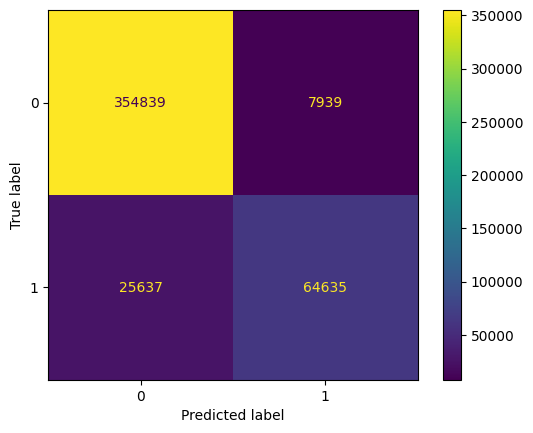

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# y_true = actual labels, y_pred = predicted labels
cm = confusion_matrix(y_test, y_pred)

# To display it as a plot:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initializing the XGBoost Classifier model
model = XGBClassifier(random_state=42)

# Training the model on the scaled training data
model.fit(X_train_scaled, y_train)

# Predicting the target values (y) for the test set
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.9259

              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95    362778
         1.0       0.89      0.72      0.79     90272

    accuracy                           0.93    453050
   macro avg       0.91      0.85      0.87    453050
weighted avg       0.92      0.93      0.92    453050



## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initializing the Random Forest Classifier model
model = RandomForestClassifier(random_state=42)

# Training the model on the non-scaled training data
model.fit(X_train, y_train)

# Predicting the target values (y) for the non-scaled test set
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.9250

              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95    362778
         1.0       0.88      0.72      0.79     90272

    accuracy                           0.92    453050
   macro avg       0.91      0.85      0.87    453050
weighted avg       0.92      0.92      0.92    453050



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initializing the Random Forest Classifier model
model = RandomForestClassifier(random_state=42)

# Training the model on the scaled training data
model.fit(X_train_scaled, y_train)

# Predicting the target values (y) for the test set
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.9250

              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95    362778
         1.0       0.88      0.72      0.79     90272

    accuracy                           0.93    453050
   macro avg       0.91      0.85      0.87    453050
weighted avg       0.92      0.93      0.92    453050



## Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer

# Initialize the Gradient Boosting Classifier model
model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,  # to prevents overfitting
    max_depth=3,
    random_state=42
)

# Impute missing values using SimpleImputer before fitting the model
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Impute missing values in y_train using SimpleImputer with 'most_frequent' strategy
imputer_y = SimpleImputer(strategy='most_frequent')
# Convert y_train to a NumPy array before reshaping
y_train_imputed = imputer_y.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_train_imputed = y_train_imputed.ravel() # Flatten back to original shape

# Train the model on the imputed training data
model.fit(X_train_imputed, y_train_imputed)

# Predict the target values for the imputed test set
y_pred = model.predict(X_test_imputed)

# Evaluate the model's performance
y_test_no_nan = y_test.dropna()  # Remove rows with NaNs from y_test
y_pred_no_nan = model.predict(X_test_imputed[y_test.notna()])

accuracy = accuracy_score(y_test_no_nan, y_pred_no_nan)

print(f'Accuracy: {accuracy:.4f}\n')

print(classification_report(y_test_no_nan, y_pred_no_nan))

Accuracy: 0.9189

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95    362021
         1.0       0.86      0.70      0.78     90085

    accuracy                           0.92    452106
   macro avg       0.90      0.84      0.86    452106
weighted avg       0.92      0.92      0.92    452106



## Guassian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Initializing the Naive Bayes Classifier model
model = GaussianNB()

# Training the model on the non-scaled training data
model.fit(X_train, y_train)

# Predicting the target values (y) for the test set
y_pred = model.predict(X_test)

# Evaluating the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.9090

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94    362778
         1.0       0.79      0.74      0.76     90272

    accuracy                           0.91    453050
   macro avg       0.86      0.85      0.85    453050
weighted avg       0.91      0.91      0.91    453050



In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Initializing the Naive Bayes Classifier model
model = GaussianNB()

# Training the model on the non-scaled training data
model.fit(X_train_scaled, y_train)

# Predicting the target values (y) for the test set
y_pred = model.predict(X_test)

# Evaluating the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}\n')

print(classification_report(y_test, y_pred))

## **Neural Network Model**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam

# Assuming 'ARR_DEL15' is the target variable and it's already binary (0, 1)
X = df.drop('ARR_DEL15', axis=1).values  # Input features
y = df['ARR_DEL15'].values  # Target column

# Data normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Neural network architecture
model = Sequential([
    Dense(64, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=HeNormal()),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_initializer=HeNormal()),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Adjusted optimizer with a lower learning rate
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Model training
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
57722/57722 ━━━━━━━━━━━━━━━━━━━━ 134s 2ms/step - accuracy: 0.7837 - loss: nan - val_accuracy: 0.7840 - val_loss: nan
Epoch 2/2
57722/57722 ━━━━━━━━━━━━━━━━━━━━ 129s 2ms/step - accuracy: 0.7842 - loss: nan - val_accuracy: 0.7840 - val_loss: nan
14431/14431 - 22s - 2ms/step - accuracy: 0.7840 - loss: nan
Test Accuracy: 0.7840


# Understanding the impact of different scaling techniques on these two models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.metrics import accuracy_score, classification_report


# Define scalers
scalers = {
    'none': None,
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'normal': Normalizer()
}

# Define models
models = {
    'LR': LogisticRegression(max_iter=1000),
    'DT': DecisionTreeClassifier(random_state=42)
}

# List to store results for dataframe
results = []

# Loop through each scaler and model
for scaler_name, scaler in scalers.items():

    if scaler is not None:
      X_train_scaled = scaler.fit_transform(X_train)
      X_test_scaled = scaler.transform(X_test)
    else:
      X_train_scaled = X_train
      X_test_scaled = X_test

    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        report = classification_report(y_test, y_pred, output_dict=True)

        results.append({
        'Model': model_name,
        'Scaler': scaler_name,
        'Accuracy': report['accuracy'],
        'Precision (Class 1)': report['1.0']['precision'],
        'Recall (Class 1)': report['1.0']['recall'],
        'F1-Score (Class 1)': report['1.0']['f1-score']
    })

# Convert results to a DataFrame for nice display
results_df = pd.DataFrame(results)



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
results_df.sort_values(by='Model', ascending= False)


,Model,Scaler,Accuracy,Precision (Class 1),Recall (Class 1),F1-Score (Class 1)
0,LR,none,0.914259,0.866409,0.673542,0.757898
2,LR,standard,0.915848,0.848590,0.703119,0.769036
4,LR,minmax,0.912921,0.844199,0.690391,0.759587
6,LR,normal,0.815674,0.836635,0.093096,0.167549
1,DT,none,0.882931,0.699933,0.721985,0.710788
3,DT,standard,0.882894,0.699849,0.721874,0.710691
5,DT,minmax,0.883017,0.700141,0.722206,0.711002
7,DT,normal,0.880468,0.696302,0.709600,0.702888


# Answering Interesting Questions

## Q1) In this specific year, what are the top 10 busiest airports?

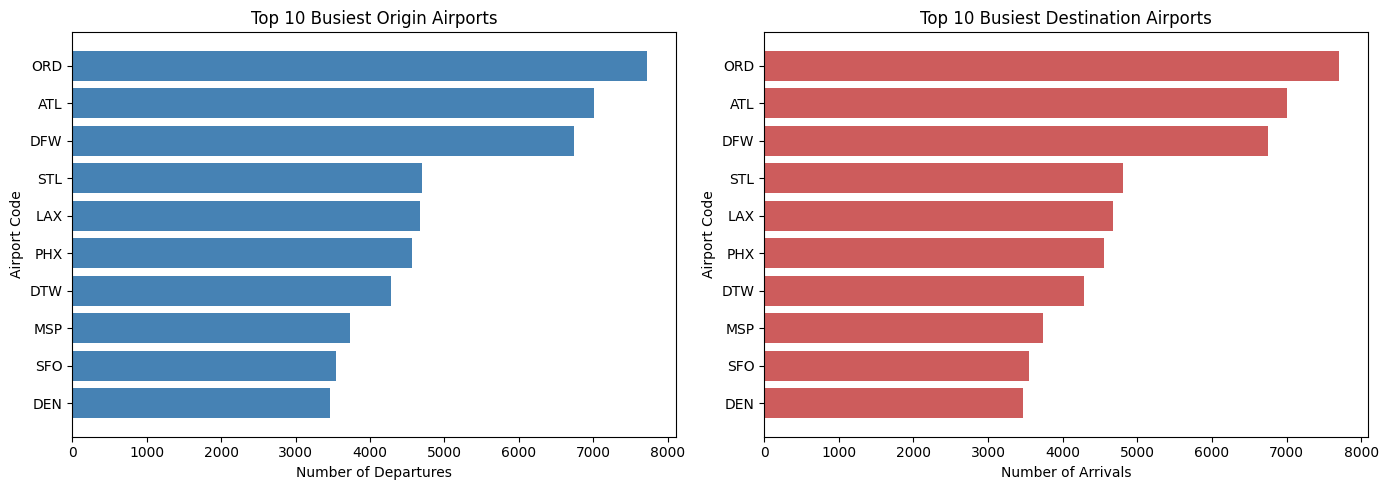

In [ ]:
# We have taken the top 10 busiest origin airports based on the number of departures
top_origins = df['ORIGIN'].value_counts().head(10)
# We have taken the top 10 busiest destination airports based on the number of arrivals
top_destinations = df['DEST'].value_counts().head(10)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# We have plotted the horizontal bar chart for top origin airports
axes[0].barh(top_origins.index[::-1], top_origins.values[::-1], color='steelblue')
axes[0].set_title('Top 10 Busiest Origin Airports')
axes[0].set_xlabel('Number of Departures')
axes[0].set_ylabel('Airport Code')

# We have plotted the horizontal bar chart for top destination airports
axes[1].barh(top_destinations.index[::-1], top_destinations.values[::-1], color='indianred')
axes[1].set_title('Top 10 Busiest Destination Airports')
axes[1].set_xlabel('Number of Arrivals')
axes[1].set_ylabel('Airport Code')

plt.tight_layout()
plt.show()


**Observation:**


1.  There is no major directional bias in the flight data.
2.  If an airport is primarily a hub, you'd expect a very close match between take-offs and landings.



## Q2) What is the average delay time for each airline?


In [ ]:
df.head()

,YEAR,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,DEP_TIME,DEP_DEL15,DEP_DELAY_GROUP,TAXI_OUT,WHEELS_OFF,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP
0,1998,1,3,AA,ABQ,NM,DFW,TX,548.0,0.0,-1.0,11.0,559.0,0.0,0.0,0.0,96.0,569.0,3.0
1,1998,1,3,AA,ABQ,NM,DFW,TX,703.0,0.0,-1.0,12.0,715.0,0.0,0.0,0.0,102.0,569.0,3.0
2,1998,1,3,AA,ABQ,NM,DFW,TX,856.0,0.0,-1.0,10.0,906.0,0.0,0.0,0.0,108.0,569.0,3.0
3,1998,1,3,AA,ABQ,NM,DFW,TX,1334.0,0.0,0.0,9.0,1343.0,0.0,0.0,0.0,100.0,569.0,3.0
4,1998,1,3,AA,ABQ,NM,DFW,TX,1635.0,0.0,-1.0,12.0,1647.0,0.0,0.0,0.0,104.0,569.0,3.0


## Q3) Which are the top 10 airlines with the most delay time?

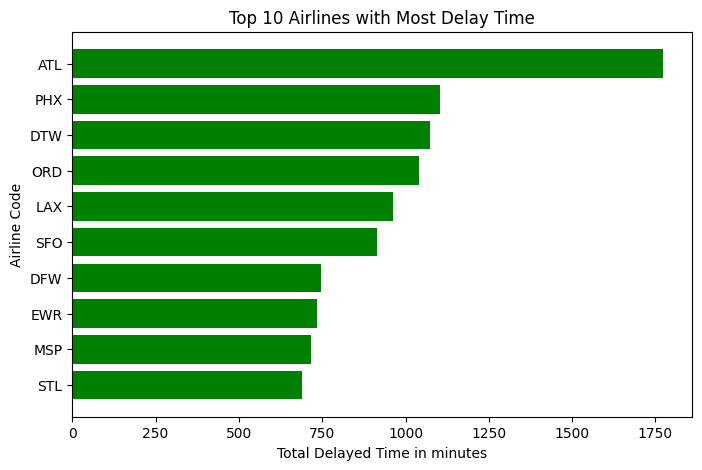

In [ ]:
# We have grouped the data by origin airport and sum up the departure delays for each of the airport.
# We have selected the top 10 airports with the most delays
top_delayed_airlines = df.groupby('ORIGIN')['DEP_DEL15'].apply(lambda x: x.fillna(0).astype(int).sum()).nlargest(10)

# Plot the results
plt.figure(figsize=(8, 5))
plt.barh(top_delayed_airlines.index[::-1], top_delayed_airlines.values[::-1], color='green')
plt.title('Top 10 Airlines with Most Delay Time')
plt.xlabel('Total Delayed Time in minutes')
plt.ylabel('Airline Code')
plt.show()

## Q4) What is the most common delay types?

Most common delay type: Arrival Delays (ARR_DEL15) with 28531 total minutes of delay


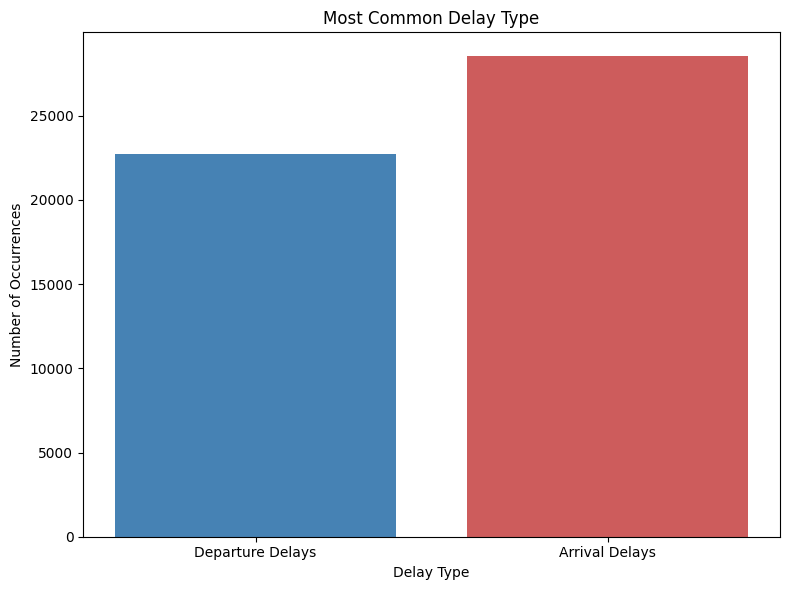

In [ ]:
# We have calculated the total number of departure delays by adding the DEP_DEL15 column.
departure_delays = df['DEP_DEL15'].fillna(0).astype(int).sum()
# We have calculated the total number of arrival delays by adding the ARR_DEL15 column.
arrival_delays = df['ARR_DEL15'].fillna(0).astype(int).sum()

# We are comparing the total departure delays and arrival delays to determine the most common delay type.
if departure_delays > arrival_delays:
    most_common_delay_type = "Departure Delays (DEP_DEL15)"
else:
    most_common_delay_type = "Arrival Delays (ARR_DEL15)"

# Printing the most common delay type and its total count.
print(f"Most common delay type: {most_common_delay_type} with {max(departure_delays, arrival_delays)} total minutes of delay")

delay_types = ['Departure Delays', 'Arrival Delays']
delay_counts = [departure_delays, arrival_delays]

plt.figure(figsize=(8, 6))
plt.bar(delay_types, delay_counts, color=['steelblue', 'indianred'])
plt.title('Most Common Delay Type')
plt.xlabel('Delay Type')
plt.ylabel('Number of Occurrences')
plt.tight_layout()
plt.show()

## Q5) How does distance relate to delay time?

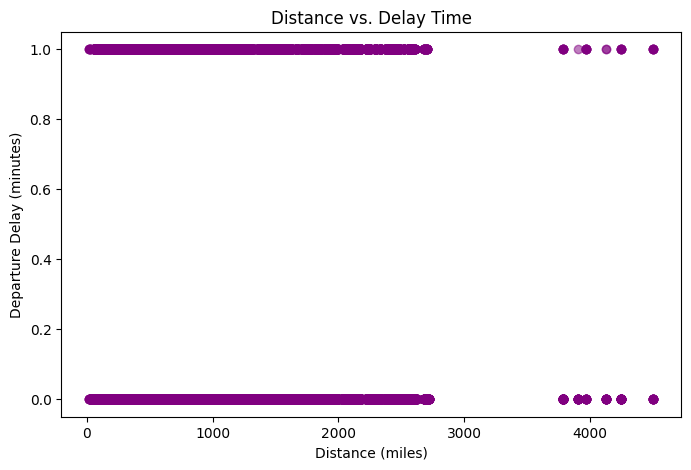

In [ ]:
df_filtered = df[['DISTANCE', 'DEP_DEL15']].dropna()

# Scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(df_filtered['DISTANCE'], df_filtered['DEP_DEL15'], alpha=0.5, color='purple')
plt.title('Distance vs. Delay Time')
plt.xlabel('Distance (miles)')
plt.ylabel('Departure Delay (minutes)')
plt.show()

## Q6) Which airport has the best on-time performance?

Best on-time performance (within top 10): BFL with 100.00% of flights arriving on time


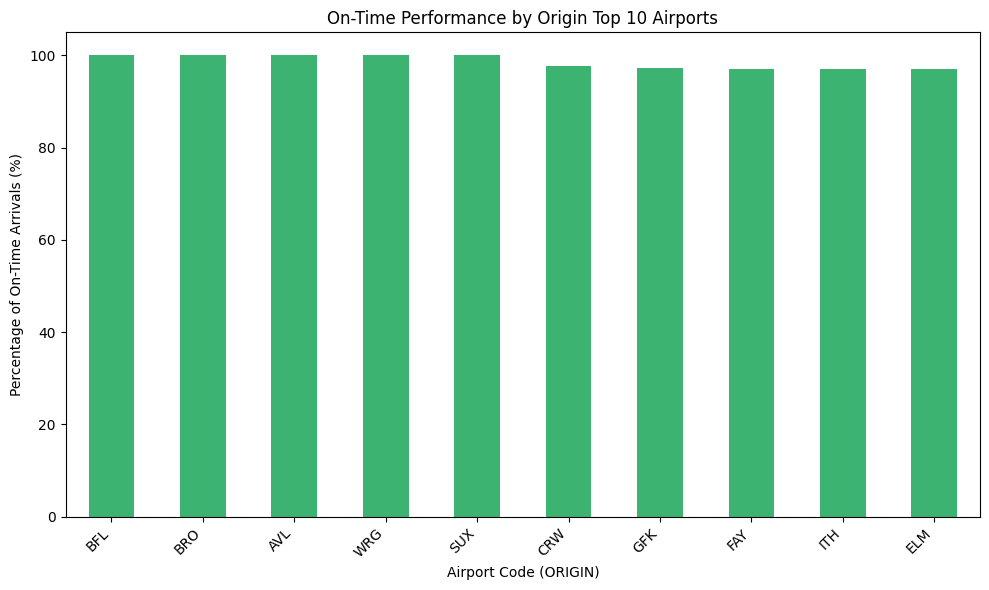

In [ ]:
df['ON_TIME'] = df['ARR_DEL15'] == 0

on_time_performance = df.groupby('ORIGIN')['ON_TIME'].mean().sort_values(ascending=False) * 100

# Select the top 10 origin airports with the best on-time performance
top_n = 10
top_on_time_performance = on_time_performance.head(top_n)

# Find the origin airport with the best performance within the top 10 airlines
best_origin = top_on_time_performance.idxmax()
best_performance = top_on_time_performance.max()

print(f"Best on-time performance (within top 10): {best_origin} with {best_performance:.2f}% of flights arriving on time")

plt.figure(figsize=(10, 6))
top_on_time_performance.plot(kind='bar', color='mediumseagreen')
plt.title('On-Time Performance by Origin Top 10 Airports')
plt.ylabel('Percentage of On-Time Arrivals (%)')
plt.xlabel('Airport Code (ORIGIN)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Q7) Are delays more common on weekends or weekdays?

Delay proportion on weekdays: 21.81%
Delay proportion on weekends: 12.76%


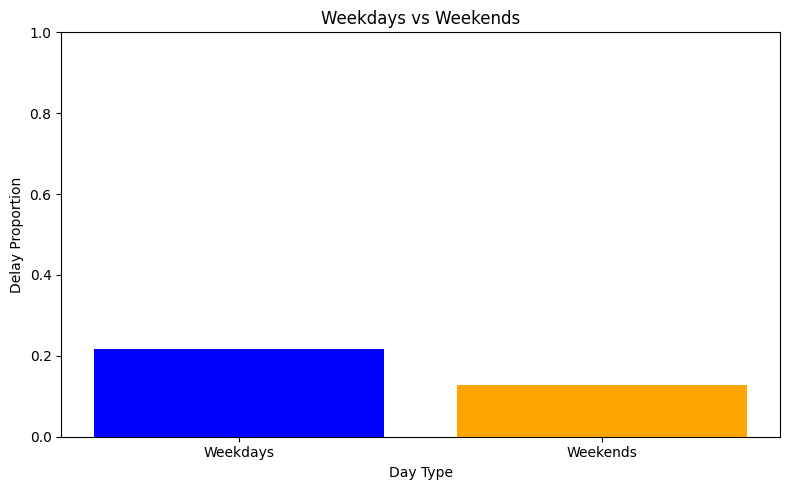

In [ ]:
# Define weekdays (1-5) and weekends (6-7) using existing 'DAY_OF_WEEK'
df['IS_WEEKEND'] = df['DAY_OF_WEEK'] >= 6

# Calculate the probability of delay for weekdays and weekends
weekend_delay_probability = df[df['IS_WEEKEND']]['ARR_DEL15'].fillna(0).astype(int).mean()
weekday_delay_probability = df[~df['IS_WEEKEND']]['ARR_DEL15'].fillna(0).astype(int).mean()

# Calculate probabilities of no delay
weekend_no_delay_probability = 1 - weekend_delay_probability
weekday_no_delay_probability = 1 - weekday_delay_probability

# Print probabilities
print(f"Probability of delay on weekdays: {weekday_delay_probability:.2%}")
print(f"Probability of delay on weekends: {weekend_delay_probability:.2%}")
print(f"Probability of NO delay on weekdays: {weekday_no_delay_probability:.2%}")
print(f"Probability of NO delay on weekends: {weekend_no_delay_probability:.2%}")

# Verify that probabilities add up to 1 for each day type
print(f"Total probability for weekdays (should be 1): {weekday_delay_probability + weekday_no_delay_probability:.2f}")
print(f"Total probability for weekends (should be 1): {weekend_delay_probability + weekend_no_delay_probability:.2f}")

labels = ['Weekdays', 'Weekends']
delays = [weekday_delay_proportion, weekend_delay_proportion]

plt.figure(figsize=(8, 5))
plt.bar(labels, delays, color=['blue', 'orange'])
plt.title('Weekdays vs Weekends')
plt.ylabel('Delay Proportion')
plt.xlabel('Day Type')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## Q8) What is the average delay time per airline?

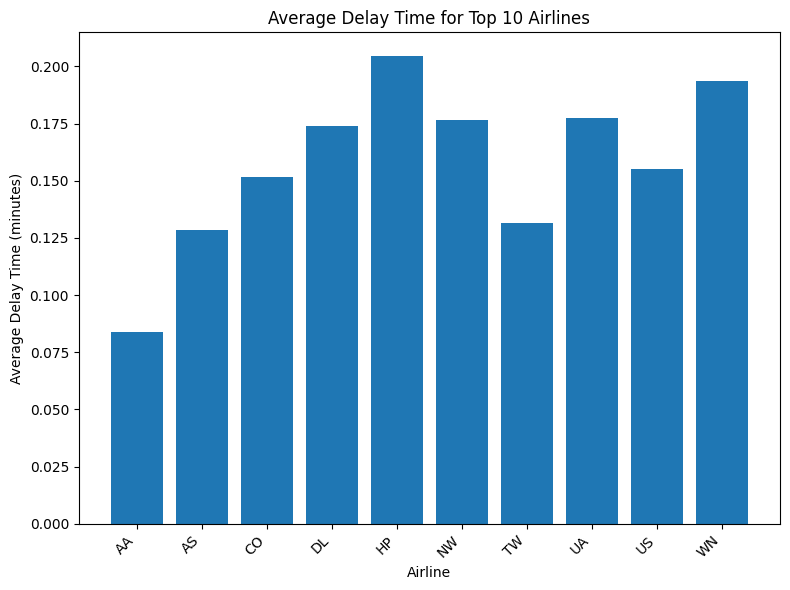

In [ ]:
# Group the data by airline and calculate the average delay time for each group
average_delay_per_airline = df.groupby(['OP_UNIQUE_CARRIER'])['DEP_DEL15'].apply(lambda x: x.fillna(0).astype(int).mean()).reset_index()


top_10_airlines = average_delay_per_airline.sort_values(by=['DEP_DEL15'], ascending=False).head(10)

# We considered all airlines but to improve the graph's clarity we have filtered the data to include only the top 10 airlines because the graph was merging data for all airlines.
# Change is in the line below
filtered_data = average_delay_per_airline[average_delay_per_airline['OP_UNIQUE_CARRIER'].isin(top_10_airlines['OP_UNIQUE_CARRIER'])]

plt.figure(figsize=(8, 6))
plt.bar(filtered_data['OP_UNIQUE_CARRIER'], filtered_data['DEP_DEL15'])
plt.title('Average Delay Time for Top 10 Airlines')
plt.xlabel('Airline')
plt.ylabel('Average Delay Time (minutes)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Q9) Which airports are the worst for delays?

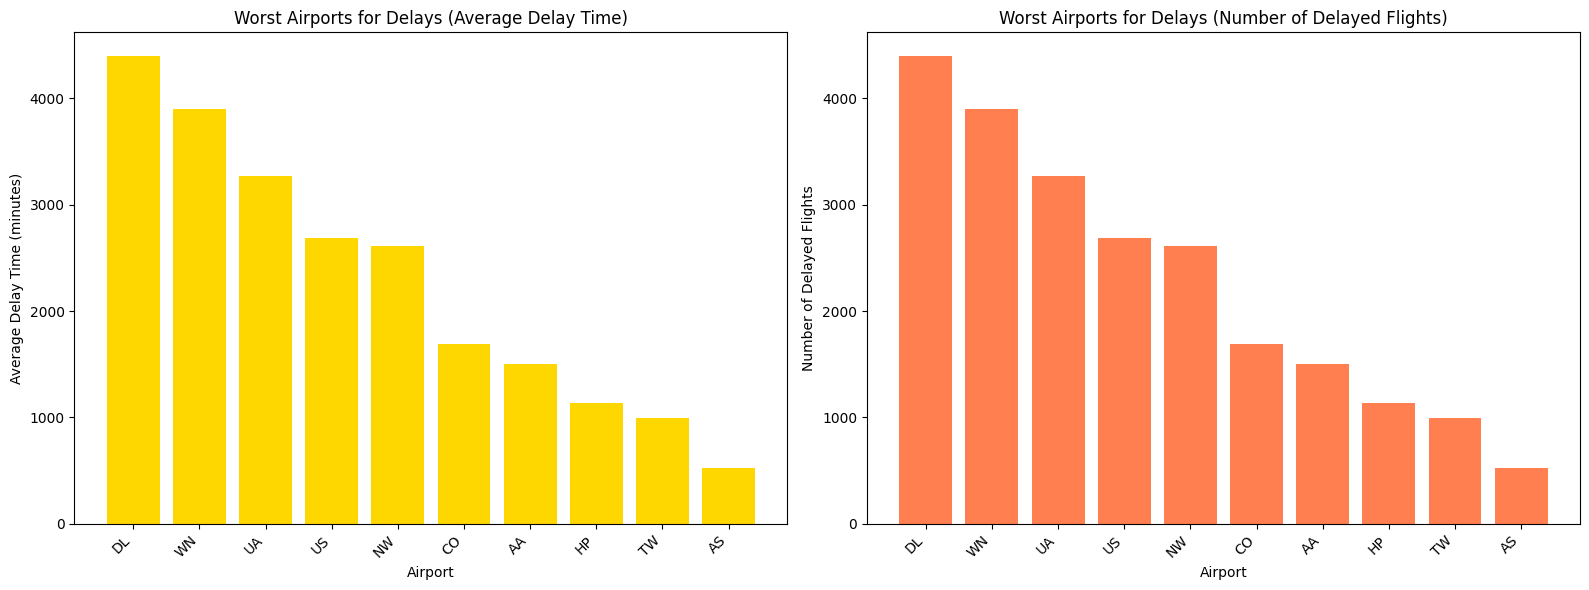

In [ ]:
# We have calculated average delay per airport
average_delay_per_airport = df.groupby('OP_UNIQUE_CARRIER')['DEP_DEL15'].apply(lambda x: x.fillna(0).astype(int).sum()).sort_values(ascending=False)
worst_airports_avg_delay = average_delay_per_airport.head(10)

# We have calculated number of delayed flights per airport
delayed_flights_per_airport = df.groupby('OP_UNIQUE_CARRIER')['DEP_DEL15'].apply(lambda x: x.fillna(0).astype(int).sum()).sort_values(ascending=False)
worst_airports_num_delays = delayed_flights_per_airport.head(10)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for average delay time
axes[0].bar(worst_airports_avg_delay.index, worst_airports_avg_delay.values, color='gold')
axes[0].set_title('Worst Airports for Delays (Average Delay Time)')
axes[0].set_xlabel('Airport')
axes[0].set_ylabel('Average Delay Time (minutes)')
axes[0].set_xticks(axes[0].get_xticks())
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')


# Plot for number of delayed flights
axes[1].bar(worst_airports_num_delays.index, worst_airports_num_delays.values, color='coral')
axes[1].set_title('Worst Airports for Delays (Number of Delayed Flights)')
axes[1].set_xlabel('Airport')
axes[1].set_ylabel('Number of Delayed Flights')
axes[1].set_xticks(axes[1].get_xticks())
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Q10) What is the probability of a flight being delayed if it is scheduled after 6 PM?

In [ ]:
df['DEP_TIME_HOURS'] = df['DEP_TIME']

# Filter flights scheduled after 6 PM
flights_after_6pm = df[df['DEP_TIME_HOURS'] >= 18]

# Calculate probability of delay after 6 PM
probability_delay_after_6pm = flights_after_6pm['ARR_DEL15'].fillna(0).astype(int).mean()

# Calculate the probability of flights NOT being delayed after 6 PM
probability_no_delay_after_6pm = 1 - probability_delay_after_6pm


print(f"Probability of a flight being delayed if it is scheduled after 6 PM is {probability_delay_after_6pm:.2%}")
print(f"Probability of a flight NOT being delayed if it is scheduled after 6 PM is {probability_no_delay_after_6pm:.2%}")

total_probability = probability_delay_after_6pm + probability_no_delay_after_6pm
print(f"Total probability (should be 1): {total_probability:.2f}")

Probability of a flight being delayed if it is scheduled after 6 PM is 20.36%
